In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False

# Train/test/val dataset with receptor clustering

In [3]:
from pathlib import Path
import requests

peptide_url = 'http://bioinfo.dcc.ufmg.br/propedia/public/download/peptide.fasta'
receptor_url = 'http://bioinfo.dcc.ufmg.br/propedia/public/download/receptor.fasta'
peptide_data = requests.get(peptide_url).text
receptor_data = requests.get(receptor_url).text
with open('peptide.fasta', 'w') as f:
  f.write(peptide_data)
with open('receptor.fasta', 'w') as f:
  f.write(receptor_data)

peptides, receptors = [], []
with open('receptor.fasta', 'r') as f:
    for line in f.readlines():
        if not line.startswith('>'):
            receptors.append(line.replace('\n', ''))

with open('peptide.fasta', 'r') as f:
    for line in f.readlines():
        if not line.startswith('>'):
            peptides.append(line.replace('\n', ''))
assert len(peptides) == len(receptors)

In [4]:
!wget https://mmseqs.com/latest/mmseqs-linux-avx2.tar.gz
!tar xvzf mmseqs-linux-avx2.tar.gz
!cp mmseqs/bin/mmseqs /usr/bin/
!pip install biopython

--2023-11-17 02:22:53--  https://mmseqs.com/latest/mmseqs-linux-avx2.tar.gz
Resolving mmseqs.com (mmseqs.com)... 147.46.145.74
Connecting to mmseqs.com (mmseqs.com)|147.46.145.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45106026 (43M) [application/octet-stream]
Saving to: ‘mmseqs-linux-avx2.tar.gz’

mmseqs-linux-avx2.t 100%[===================>]  43.02M  6.72MB/s    in 6.0s    

2023-11-17 02:23:00 (7.15 MB/s) - ‘mmseqs-linux-avx2.tar.gz’ saved [45106026/45106026]

mmseqs/
mmseqs/bin/
mmseqs/bin/mmseqs
mmseqs/LICENSE.md
mmseqs/examples/
mmseqs/examples/DB.fasta
mmseqs/examples/QUERY.fasta
mmseqs/README.md
mmseqs/matrices/
mmseqs/matrices/PAM40.out
mmseqs/matrices/PAM190.out
mmseqs/matrices/blosum85.out
mmseqs/matrices/PAM170.out
mmseqs/matrices/blosum35.out
mmseqs/matrices/PAM70.out
mmseqs/matrices/blosum45.out
mmseqs/matrices/blosum60.out
mmseqs/matrices/blosum62.out
mmseqs/matrices/blosum80.out
mmseqs/matrices/PAM10.out
mmseqs/matrices/blosum50.out
mm

In [5]:
!mmseqs createdb receptor.fasta receptorDB
!mmseqs cluster receptorDB receptorDB_clu tmp --min-seq-id 0.5
!mmseqs createtsv receptorDB receptorDB receptorDB_clu receptorDB_clu.tsv

createdb receptor.fasta receptorDB 

MMseqs Version:       	9b9383a3f0c7a99fef37640823174368f74c1487
Database type         	0
Shuffle input database	true
Createdb mode         	0
Write lookup file     	1
Offset of numeric ids 	0
Compressed            	0
Verbosity             	3

Converting sequences
[19797] 0s 43ms
Time for merging to receptorDB_h: 0h 0m 0s 8ms
Time for merging to receptorDB: 0h 0m 0s 12ms
Database type: Aminoacid
Time for processing: 0h 0m 0s 116ms
Create directory tmp
cluster receptorDB receptorDB_clu tmp --min-seq-id 0.5 

MMseqs Version:                     	9b9383a3f0c7a99fef37640823174368f74c1487
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,n

In [6]:
from Bio import SeqIO
id_to_seq = {}
receptors_parsed = list(SeqIO.parse('receptor.fasta', 'fasta'))
for receptor_parsed in receptors_parsed:
    id_to_seq[receptor_parsed.id] = str(receptor_parsed.seq)
receptor_to_peptide = dict(zip(receptors, peptides))

with open('receptorDB_clu.tsv', 'r') as f:
    clusters = {}
    for line in f:
        cluster_id, receptor_id = line.strip().split("\t")
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        receptor_sequence = id_to_seq[receptor_id]
        peptide_sequence = receptor_to_peptide[receptor_sequence]
        clusters[cluster_id].append((peptide_sequence, receptor_sequence))

set_seed()

cluster_ids = list(clusters.keys())
random.shuffle(cluster_ids)
num_train = int(0.7 * len(cluster_ids))
num_val = int(0.15 * len(cluster_ids))
train_clusters = cluster_ids[:num_train]
val_clusters = cluster_ids[num_train:num_train+num_val]
test_clusters = cluster_ids[num_train+num_val:]

In [7]:
class PeptideReceptorDataset(Dataset):
    def __init__(self, clusters, cluster_ids):
        self.clusters = clusters
        self.cluster_ids = cluster_ids

    def __len__(self):
        return len(self.cluster_ids)

    def __getitem__(self, idx):
        curr_cluster = self.clusters[self.cluster_ids[idx]]
        curr_pair = random.choice(curr_cluster)
        peptide_sequence = curr_pair[0]
        receptor_sequence = curr_pair[1]
        return peptide_sequence, receptor_sequence

train_dataset = PeptideReceptorDataset(clusters, train_clusters)
val_dataset = PeptideReceptorDataset(clusters, val_clusters)
test_dataset = PeptideReceptorDataset(clusters, test_clusters)

# Model helpers

## ExtendedCLIP definition

In [8]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.6 MB/s eta 0:00:00


In [9]:
from transformers import EsmModel, EsmTokenizer
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t30_150M_UR50D")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
esm_model = EsmModel.from_pretrained("facebook/esm2_t30_150M_UR50D").to(device)
for param in esm_model.parameters():
    param.requires_grad = False

(…)UR50D/resolve/main/tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

(…)m2_t30_150M_UR50D/resolve/main/vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

(…)50D/resolve/main/special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

(…)_t30_150M_UR50D/resolve/main/config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
def masked_mean(h, mask):
    sum_masked_h = torch.sum(h * mask.unsqueeze(-1), dim=1)
    count_non_masked = mask.sum(dim=1, keepdim=True).clamp_(min=1)
    mean_masked_h = sum_masked_h.div_(count_non_masked)
    return mean_masked_h

def masked_max(h, mask):
    masked_h = h * mask.unsqueeze(-1)
    max_masked_h, _ = torch.max(masked_h, dim=1)
    return max_masked_h

class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, h1, h2, dropout_rate):
        super(Encoder, self).__init__()
        self.projection = nn.Linear(input_dim, embedding_dim)
        self.amino_acid_ffn = self._build_ffn(embedding_dim, h1, dropout_rate)
        self.embedding_ffn = self._build_ffn(embedding_dim, h2, dropout_rate)

    def _build_ffn(self, embedding_dim, depth, dropout_rate):
        layers = [nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(inplace=True),
            nn.LayerNorm(embedding_dim),
            nn.Dropout(dropout_rate)
        ) for _ in range(depth - 1)]
        layers.append(nn.Linear(embedding_dim, embedding_dim))
        return nn.Sequential(*layers)

    def forward(self, seq):
        input_ids = seq['input_ids']
        attn_mask = seq['attention_mask']
        # temperature = seq['temperature']
        esm_embedding = esm_model(input_ids=input_ids, attention_mask=attn_mask).last_hidden_state
        embedding = self.projection(esm_embedding)
        amino_acid_embedding = self.amino_acid_ffn(embedding)
        # max_amino_acid_embedding = masked_max(amino_acid_embedding, attn_mask)
        # embedding_output = self.embedding_ffn(max_amino_acid_embedding)
        # normed_embedding = F.normalize(embedding_output, dim=-1)
        # scaled_embedding = normed_embedding * torch.exp(temperature / 2)
        return amino_acid_embedding

class ExtendedCLIP(nn.Module):
    def __init__(self, input_dim, embedding_dim, h1, h2, dropout):
        super(ExtendedCLIP, self).__init__()
        self.pep_encoder = Encoder(input_dim, embedding_dim, h1, h2, dropout)
        self.rec_encoder = Encoder(input_dim, embedding_dim, h1, h2, dropout)
        self.t = nn.Parameter(torch.tensor(1.0))

    def forward(self, pep_seq, rec_seq):
        pep_seq['temperature'] = self.t
        rec_seq['temperature'] = self.t
        pep_embedding = self.pep_encoder(pep_seq)
        rec_embedding = self.rec_encoder(rec_seq)
        return pep_embedding, rec_embedding

def compute_similarity_matrix(model, peptides, receptors):
    pep_norm_embedding, rec_norm_embedding = model(peptides, receptors)
    pep_norm_embedding = masked_mean(pep_norm_embedding, peptides["attention_mask"])
    pep_norm_embedding = model.pep_encoder.embedding_ffn(pep_norm_embedding)
    pep_norm_embedding = F.normalize(pep_norm_embedding, dim=-1)
    pep_norm_embedding = pep_norm_embedding

    rec_norm_embedding = masked_mean(rec_norm_embedding, receptors["attention_mask"])
    rec_norm_embedding = model.rec_encoder.embedding_ffn(rec_norm_embedding)
    rec_norm_embedding = F.normalize(rec_norm_embedding, dim=-1)
    rec_norm_embedding = rec_norm_embedding


    similarity_matrix = torch.mm(pep_norm_embedding, rec_norm_embedding.t())
    return similarity_matrix * torch.exp(-model.t)

def compute_token_max_similarity(pep_embedding, rec_embedding):
    max_similarities = []
    for i in range(pep_embedding.size(0)):
        peptide = pep_embedding[i]
        receptor = rec_embedding[i]
        token_similarities = torch.mm(peptide, receptor.t())
        max_similarity, _ = torch.max(token_similarities, dim=1)
        max_similarities.append(max_similarity)
    return torch.stack(max_similarities)

## Original train/eval functions

In [61]:
def compute_loss(pep_embedding, rec_embedding):
    logits = torch.mm(pep_embedding, rec_embedding)
    exp_logits = torch.exp(logits)
    L_r = -torch.mean(torch.log(torch.exp(torch.diag(logits)) / torch.sum(exp_logits, dim=1)))
    L_p = -torch.mean(torch.log(torch.exp(torch.diag(logits)) / torch.sum(exp_logits, dim=0)))
    return (L_r + L_p) * 0.5

def contrastive_loss(pep_embedding, rec_embedding):
    max_similarity_pep_to_rec = compute_token_max_similarity(pep_embedding, rec_embedding)
    max_similarity_rec_to_pep = compute_token_max_similarity(rec_embedding, pep_embedding)

    device = pep_embedding.device

    def compute_loss(similarity_matrix, positive_indices):
        positive_indices = positive_indices.to(device)
        logits = F.log_softmax(similarity_matrix, dim=1)
        return -logits.gather(1, positive_indices.unsqueeze(1)).mean()

    # image-to-text S^I (peptide to receptor in our case) and
    # text-to-image losses S^T (receptor to peptide in our case) as described in paper
    batch_size = pep_embedding.size(0)
    positive_indices = torch.arange(batch_size)
    loss_pep_to_rec = compute_loss(max_similarity_pep_to_rec, positive_indices)
    loss_rec_to_pep = compute_loss(max_similarity_rec_to_pep, positive_indices)

    # average of the two losses
    total_loss = (loss_pep_to_rec + loss_rec_to_pep) / 2
    return total_loss

def process_batch(model, batch_data, device, compute_grad=False):
    peptides, receptors = batch_data
    peptides = tokenizer(peptides, return_tensors='pt', padding=True).to(device)
    receptors = tokenizer(receptors, return_tensors='pt', padding=True).to(device)
    pep_embedding = model.pep_encoder(peptides)
    rec_embedding = model.rec_encoder(receptors)
    loss = contrastive_loss(pep_embedding, rec_embedding)
    if compute_grad:
        loss.backward()
    return loss.item()


def train(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch_data in data_loader:
        optimizer.zero_grad()
        loss = process_batch(model, batch_data, device, compute_grad=True)
        optimizer.step()
        total_loss += loss
    return total_loss / len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_data in data_loader:
            loss = process_batch(model, batch_data, device)
            total_loss += loss
    return total_loss / len(data_loader)


## GradCache train functions

In [12]:
!git clone https://github.com/luyug/GradCache
%cd GradCache
!pip install .

Cloning into 'GradCache'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 116 (delta 14), reused 8 (delta 8), pack-reused 97
Receiving objects: 100% (116/116), 31.61 KiB | 3.51 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/GradCache
Processing /content/GradCache
  Preparing metadata (setup.py) ... done
  Created wheel for GradCache: filename=GradCache-0.0.1-py3-none-any.whl size=11558 sha256=1dcfc59a8357b8aa9d5ca31cda77fb7bc007b361aa41af7ab93d973e1b60ad5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-cfdmphbo/wheels/57/21/87/c7b10f60ffad49d32d011e48fa0e010a321798f14aad50dde9
Successfully built GradCache


In [13]:
from grad_cache.functional import cached, cat_input_tensor
from torch.cuda.amp import GradScaler, autocast

scaler = torch.cuda.amp.GradScaler()

@cached
@autocast()
def call_model(model, input):
    return model(input)

@cat_input_tensor
@autocast()
def contrastive_loss(x, y):
    logits = torch.matmul(x, y.transpose(0, 1))
    exp_logits = torch.exp(logits)
    L_r = -torch.mean(torch.log(torch.exp(torch.diag(logits)) / torch.sum(exp_logits, dim=1)))
    L_p = -torch.mean(torch.log(torch.exp(torch.diag(logits)) / torch.sum(exp_logits, dim=0)))
    loss = (L_r + L_p) * 0.5
    return loss

def train_gc(model, data_loader, optimizer, device, agg_batches=2):
    model.train()
    total_loss = 0

    cache_x = []
    cache_y = []
    closures_x = []
    closures_y = []

    big_batches = 0
    for step, sub_batch in enumerate(data_loader):
        xx, yy = sub_batch
        xx = tokenizer(xx, return_tensors='pt', padding=True).to(device)
        yy = tokenizer(yy, return_tensors='pt', padding=True).to(device)
        xx['temperature'] = model.t
        yy['temperature'] = model.t

        rx, cx = call_model(model.pep_encoder, xx)
        ry, cy = call_model(model.rec_encoder, yy)

        cache_x.append(rx)
        cache_y.append(ry)
        closures_x.append(cx)
        closures_y.append(cy)

        if (step + 1) % agg_batches == 0:
            big_batches += 1
            loss = contrastive_loss(cache_x, cache_y)
            total_loss += loss.item()
            scaler.scale(loss).backward()

            for f, r in zip(closures_x, cache_x):
                f(r)
            for f, r in zip(closures_y, cache_y):
                f(r)

            cache_x = []
            cache_y = []
            closures_x = []
            closures_y = []

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

    return total_loss / big_batches

# Model training

In [14]:
# cleaning gpu ram
import gc
gc.collect()
torch.cuda.empty_cache()

In [42]:
set_seed()
input_dim = 640
embedding_dim = 128
h1 = 2
h2 = 2
dropout = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_model = ExtendedCLIP(input_dim, embedding_dim, h1, h2, dropout).to(device)
optimizer = torch.optim.Adam(trained_model.parameters(), lr=1e-3)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

num_epochs = 25
training_with_grad_cache = False
train_losses, val_losses = [], []
best_val_loss = float('inf')
best_model_state = None

-torch.tensor(1/batch_size).log().item()

2.7725887298583984

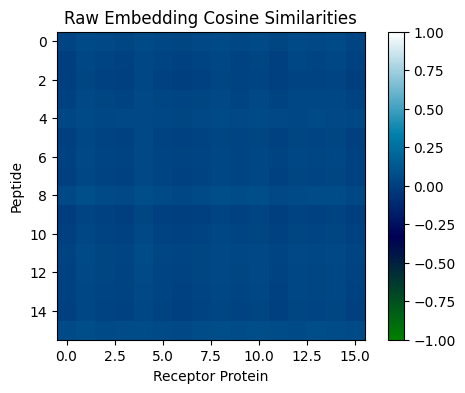

In [62]:
curr_peptides, curr_receptors = next(iter(train_loader))
curr_peptides = tokenizer(curr_peptides, return_tensors='pt', padding=True).to(device)
curr_receptors = tokenizer(curr_receptors, return_tensors='pt', padding=True).to(device)

similarity_matrix = compute_similarity_matrix(trained_model, curr_peptides, curr_receptors)
similarity_matrix_np = similarity_matrix.cpu().detach().numpy()

plt.figure(figsize=(6, 4))
plt.imshow(similarity_matrix_np, cmap="ocean", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Raw Embedding Cosine Similarities")
plt.xlabel("Receptor Protein")
plt.ylabel("Peptide")
plt.show()

del curr_peptides
del curr_receptors
del similarity_matrix
del similarity_matrix_np

In [44]:
for epoch in range(num_epochs):
    print(epoch)
    if training_with_grad_cache:
        agg_batches = 16
        train_loss = train_gc(trained_model, train_loader, optimizer, device, agg_batches)
    else:
        train_loss = train(trained_model, train_loader, optimizer, device)
    val_loss = evaluate(trained_model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = trained_model.state_dict()
        torch.save(best_model_state, 'best_model.pth')

    torch.cuda.empty_cache()
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

0
Epoch 1/25 - Train Loss: 4.4984, Val Loss: 3.8267
1
Epoch 2/25 - Train Loss: 3.8410, Val Loss: 3.5679
2
Epoch 3/25 - Train Loss: 3.6513, Val Loss: 3.4733
3
Epoch 4/25 - Train Loss: 3.5675, Val Loss: 3.4636
4
Epoch 5/25 - Train Loss: 3.5262, Val Loss: 3.4554
5
Epoch 6/25 - Train Loss: 3.4563, Val Loss: 3.3525
6
Epoch 7/25 - Train Loss: 3.4301, Val Loss: 3.3323
7
Epoch 8/25 - Train Loss: 3.4140, Val Loss: 3.3278
8
Epoch 9/25 - Train Loss: 3.3748, Val Loss: 3.3290
9
Epoch 10/25 - Train Loss: 3.3697, Val Loss: 3.2686
10
Epoch 11/25 - Train Loss: 3.3485, Val Loss: 3.3424
11
Epoch 12/25 - Train Loss: 3.3010, Val Loss: 3.3053
12
Epoch 13/25 - Train Loss: 3.3156, Val Loss: 3.2504
13
Epoch 14/25 - Train Loss: 3.3041, Val Loss: 3.2481
14
Epoch 15/25 - Train Loss: 3.2906, Val Loss: 3.2495
15
Epoch 16/25 - Train Loss: 3.2876, Val Loss: 3.2876
16
Epoch 17/25 - Train Loss: 3.2942, Val Loss: 3.2828
17
Epoch 18/25 - Train Loss: 3.2999, Val Loss: 3.2445
18
Epoch 19/25 - Train Loss: 3.2676, Val Loss: 

In [45]:
best_trained_model = ExtendedCLIP(input_dim, embedding_dim, h1, h2, dropout).to(device)
best_trained_model.load_state_dict(torch.load('best_model.pth'))
test_loss = evaluate(best_trained_model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}")

KeyboardInterrupt: ignored

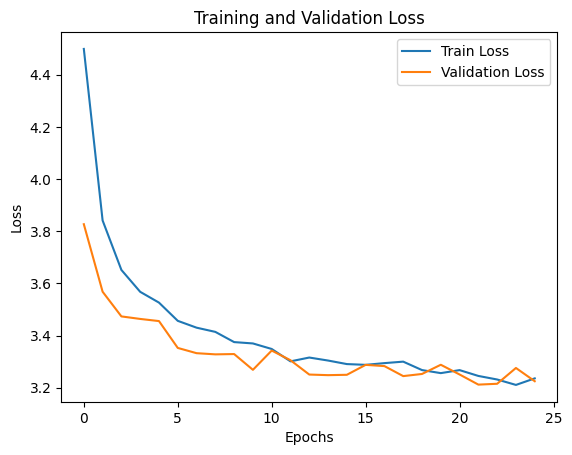

In [47]:
plt.plot([i for i in train_losses], label='Train Loss')
plt.plot([i for i in val_losses], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

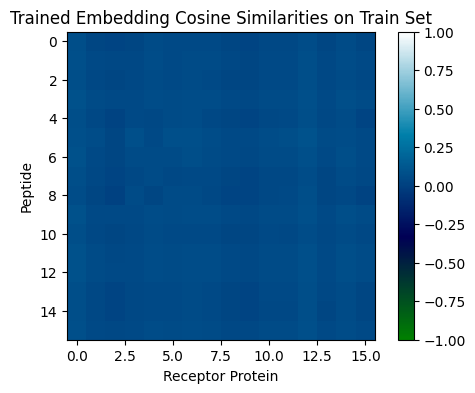

In [63]:
curr_peptides, curr_receptors = next(iter(train_loader))
curr_peptides = tokenizer(curr_peptides, return_tensors='pt', padding=True).to(device)
curr_receptors = tokenizer(curr_receptors, return_tensors='pt', padding=True).to(device)

similarity_matrix = compute_similarity_matrix(best_trained_model, curr_peptides, curr_receptors)
similarity_matrix_np = similarity_matrix.cpu().detach().numpy()

plt.figure(figsize=(6, 4))
plt.imshow(similarity_matrix_np, cmap="ocean", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Trained Embedding Cosine Similarities on Train Set")
plt.xlabel("Receptor Protein")
plt.ylabel("Peptide")
plt.show()

del curr_peptides
del curr_receptors
del similarity_matrix
del similarity_matrix_np

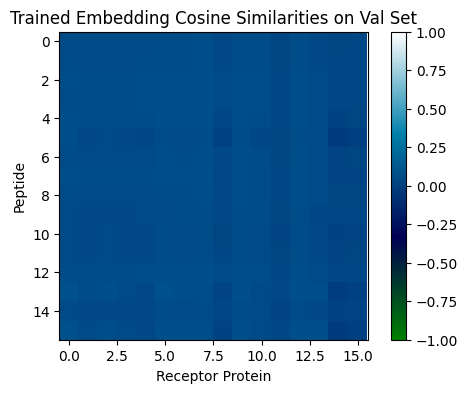

In [56]:
curr_peptides, curr_receptors = next(iter(val_loader))
curr_peptides = tokenizer(curr_peptides, return_tensors='pt', padding=True).to(device)
curr_receptors = tokenizer(curr_receptors, return_tensors='pt', padding=True).to(device)

similarity_matrix = compute_similarity_matrix(best_trained_model, curr_peptides, curr_receptors)
similarity_matrix_np = similarity_matrix.cpu().detach().numpy()

plt.figure(figsize=(6, 4))
plt.imshow(similarity_matrix_np, cmap="ocean", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Trained Embedding Cosine Similarities on Val Set")
plt.xlabel("Receptor Protein")
plt.ylabel("Peptide")
plt.show()

del curr_peptides
del curr_receptors
del similarity_matrix
del similarity_matrix_np